## Alzheimer

## Carregar Dados Pre-prontos

In [ ]:
import os
import numpy as np
import tensorflow as tf
seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)
import seaborn as sns
sns.set_context('poster')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
import sys
from utility_funcs import evaluate_thresholds

In [ ]:
base_path = r'C:\Users\decmg\OneDrive\Documentos\Material Disciplinas\MO444\data\processed'
x_train = np.load(os.path.join(base_path, 'x_train_bin.npy'))
y_train = np.load(os.path.join(base_path, 'y_train_bin.npy'))
x_val = np.load(os.path.join(base_path, 'x_val_bin.npy'))
y_val = np.load(os.path.join(base_path, 'y_val_bin.npy'))
x_test = np.load(os.path.join(base_path, 'x_test_bin.npy'))
y_test = np.load(os.path.join(base_path, 'y_test_bin.npy'))
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (31294, 256, 19), y_train shape: (31294,)
x_val shape: (10416, 256, 19), y_val shape: (10416,)
x_test shape: (11472, 256, 19), y_test shape: (11472,)


In [ ]:
np_train = (x_train, y_train)
np_val = (x_val, y_val)
np_test = (x_test, y_test)

Shape de x_train: (31294, 256, 19), Shape de y_train: (31294,)
Shape de x_train: (10416, 256, 19), Shape de y_train: (10416,)
Shape de x_train: (11472, 256, 19), Shape de y_train: (11472,)


In [16]:
from sklearn.preprocessing import StandardScaler
x_train_reshaped = x_train.reshape(-1, x_train.shape[-1])
x_val_reshaped = x_val.reshape(-1, x_val.shape[-1])
x_test_reshaped = x_test.reshape(-1, x_test.shape[-1])

In [ ]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train_reshaped)
x_val_scaled = scaler.transform(x_val_reshaped)
x_test_scaled = scaler.transform(x_test_reshaped)

x_train_scaled = x_train_scaled.reshape(x_train.shape)
x_val_scaled = x_val_scaled.reshape(x_val.shape)
x_test_scaled = x_test_scaled.reshape(x_test.shape)

x_train_scaled shape: (31294, 256, 19)
x_val_scaled shape: (10416, 256, 19)
x_test_scaled shape: (11472, 256, 19)


In [20]:
####### Crucial PARA ALZHEIMER DISEASE

########## Ajustar rótulos para serem binários (0 e 1)
y_train = np.where(y_train == 2, 1, y_train)
y_val = np.where(y_val == 2, 1, y_val)
y_test = np.where(y_test == 2, 1, y_test)

## Otimização com Optuna

In [21]:
n_timesteps = 256  # Número de passos de tempo
n_features = 19    # Número de características (features)

In [ ]:
import optuna
from utility_funcs import objective

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, x_train_scaled, y_train, x_val_scaled, y_val, n_timesteps, n_features), n_trials=20, show_progress_bar=True)

In [11]:
best_params = {
    'filters_1': 16,
    'filters_2': 128,
    'lstm_units': 100,
    'dense_units': 32,
    'dropout_rate': 0.36092071757979298,
    'learning_rate': 0.0003038390556587884,
    'l2_reg': 5.1640997546082564e-03
}

## Treinamento

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

np.random.seed(42)

model = Sequential([
    Input(shape=(n_timesteps, n_features)),
    Conv1D(filters=best_params['filters_1'], kernel_size=3, activation='relu',
           kernel_regularizer=l2(best_params['l2_reg'])),
    MaxPooling1D(pool_size=2),
    Dropout(best_params['dropout_rate']),
    
    Conv1D(filters=best_params['filters_2'], kernel_size=3, activation='relu',
           kernel_regularizer=l2(best_params['l2_reg'])),
    MaxPooling1D(pool_size=2),
    Dropout(best_params['dropout_rate']),
    
    LSTM(best_params['lstm_units'], activation='tanh', return_sequences=False,
         kernel_regularizer=l2(best_params['l2_reg'])),
    Dropout(best_params['dropout_rate']),
    
    Dense(best_params['dense_units'], activation='relu', kernel_regularizer=l2(best_params['l2_reg'])),
    Dropout(best_params['dropout_rate'] / 2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, mode='min')
]
history = model.fit(
    x_train_scaled, y_train,
    validation_data=(x_val_scaled, y_val),
    epochs=20,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.5329 - auc: 0.5004 - loss: 1.7940 - precision: 0.5482 - recall: 0.8254 - val_accuracy: 0.5409 - val_auc: 0.4843 - val_loss: 1.0597 - val_precision: 0.5411 - val_recall: 0.9989
Epoch 2/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.5496 - auc: 0.5303 - loss: 0.9652 - precision: 0.5492 - recall: 0.9654 - val_accuracy: 0.5192 - val_auc: 0.5031 - val_loss: 0.8240 - val_precision: 0.5479 - val_recall: 0.6385
Epoch 3/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.6346 - auc: 0.6691 - loss: 0.7438 - precision: 0.6539 - recall: 0.6998 - val_accuracy: 0.6410 - val_auc: 0.6722 - val_loss: 0.7224 - val_precision: 0.6770 - val_recall: 0.6442
Epoch 4/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.7149 - auc: 0.7668 - loss: 0.6370 - precision: 0.7213 - recall: 0.7767 - val_accuracy: 0.6023 - val_auc: 0.7149 - val_loss: 0.7719 - val_precision: 0.5939 - val_recall: 0.8391
Epoch 5/20
245/245 ━━━━━

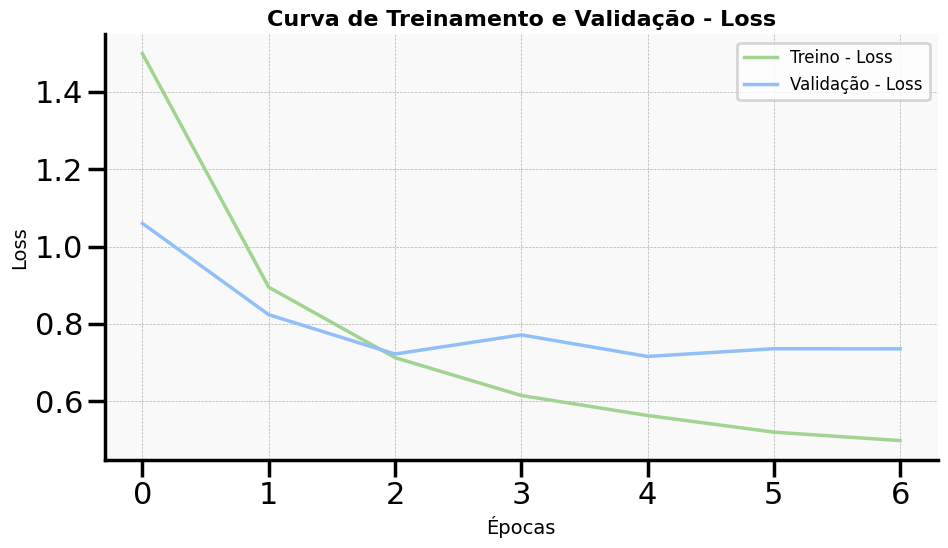

326/326 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

Métricas no Conjunto de Validação:
              precision    recall  f1-score   support

           0       0.65      0.32      0.43      4778
           1       0.60      0.86      0.70      5638

    accuracy                           0.61     10416
   macro avg       0.63      0.59      0.57     10416
weighted avg       0.62      0.61      0.58     10416

AUC no Conjunto de Validação: 0.7324208515409472


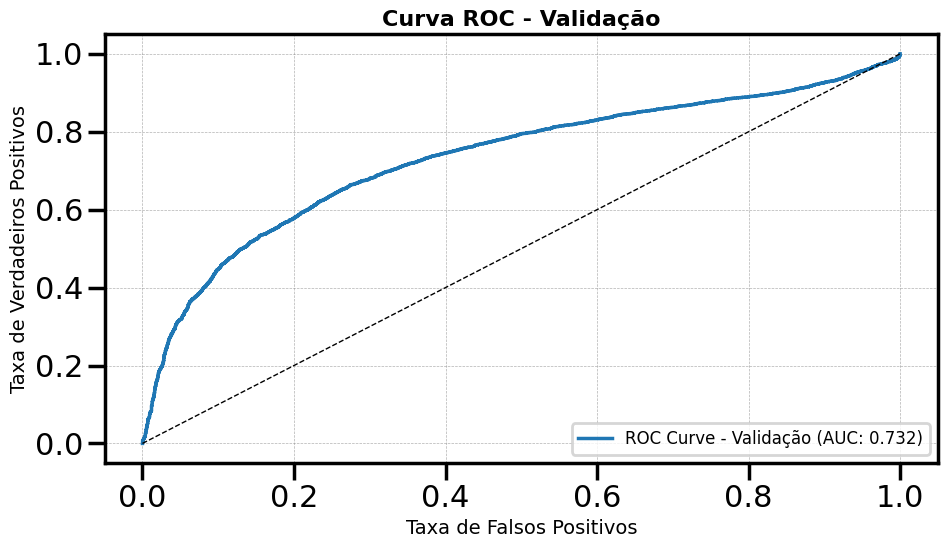

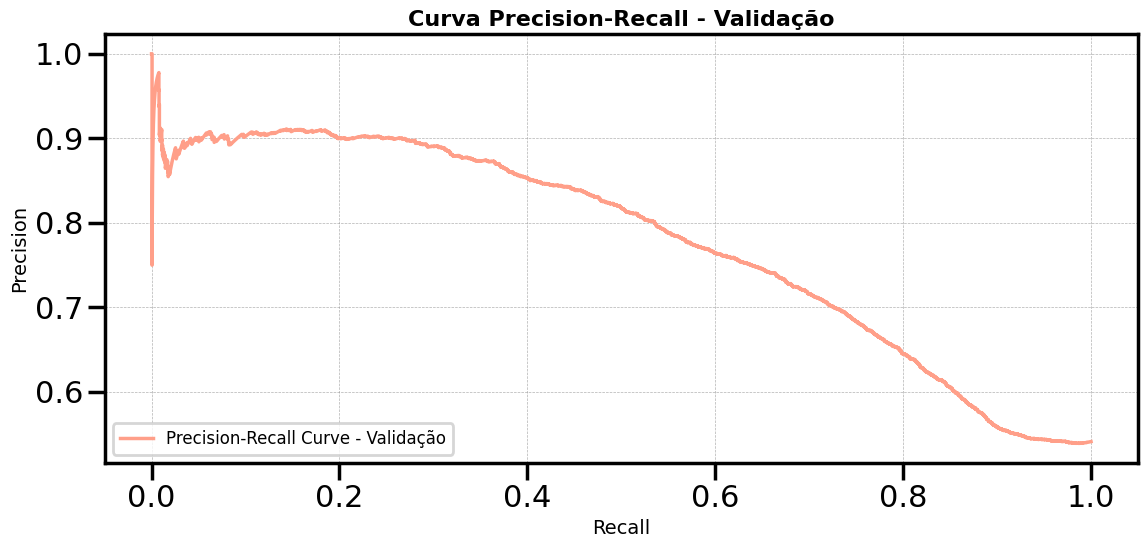

In [ ]:
from utility_funcs import plot_training_curves, plot_roc_curve, plot_precision_recall_curve

plot_training_curves(history)

y_val_pred_probs = model.predict(x_val_scaled).ravel()
y_val_pred = (y_val_pred_probs >= 0.35).astype(int)

print("\nMétricas no Conjunto de Validação:")
print(classification_report(y_val, y_val_pred))
print("AUC no Conjunto de Validação:", roc_auc_score(y_val, y_val_pred_probs))

plot_roc_curve(y_val, y_val_pred_probs)
plot_precision_recall_curve(y_val, y_val_pred_probs)

Text(0.5, 1.0, 'Matriz de Confusão para FTD')

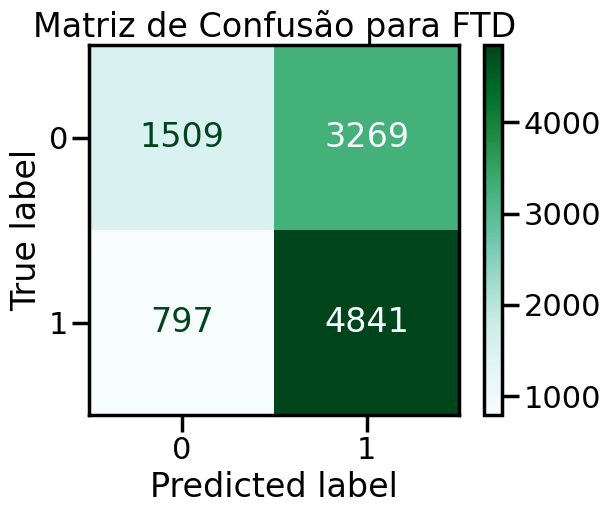

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.BuGn)
plt.title("Matriz de Confusão para FTD")

In [27]:
thresholds = np.arange(.2,.7,.025)

# Avaliar no conjunto de validação
metrics_table_val = evaluate_thresholds(y_val, y_val_pred_probs, thresholds)
print("Métricas no Conjunto de Validação:")
print(metrics_table_val)

Métricas no Conjunto de Validação:
    Threshold  Accuracy  Precision    Recall  F1-Score       AUC
0       0.200  0.553571   0.553118  0.912380  0.688713  0.732421
1       0.225  0.560100   0.558009  0.900851  0.689145  0.732421
2       0.250  0.568164   0.563773  0.893757  0.691411  0.732421
3       0.275  0.578821   0.571527  0.886485  0.694987  0.732421
4       0.300  0.588806   0.579268  0.878148  0.698061  0.732421
5       0.325  0.598022   0.586980  0.868393  0.700479  0.732421
6       0.350  0.609639   0.596917  0.858638  0.704248  0.732421
7       0.375  0.620008   0.606518  0.848350  0.707335  0.732421
8       0.400  0.628648   0.615505  0.836467  0.709173  0.732421
9       0.425  0.636617   0.624580  0.823874  0.710516  0.732421
10      0.450  0.643529   0.631976  0.817488  0.712861  0.732421
11      0.475  0.649194   0.638586  0.810748  0.714442  0.732421
12      0.500  0.653418   0.644857  0.800639  0.714354  0.732421
13      0.525  0.659370   0.652421  0.793366  0.716024 

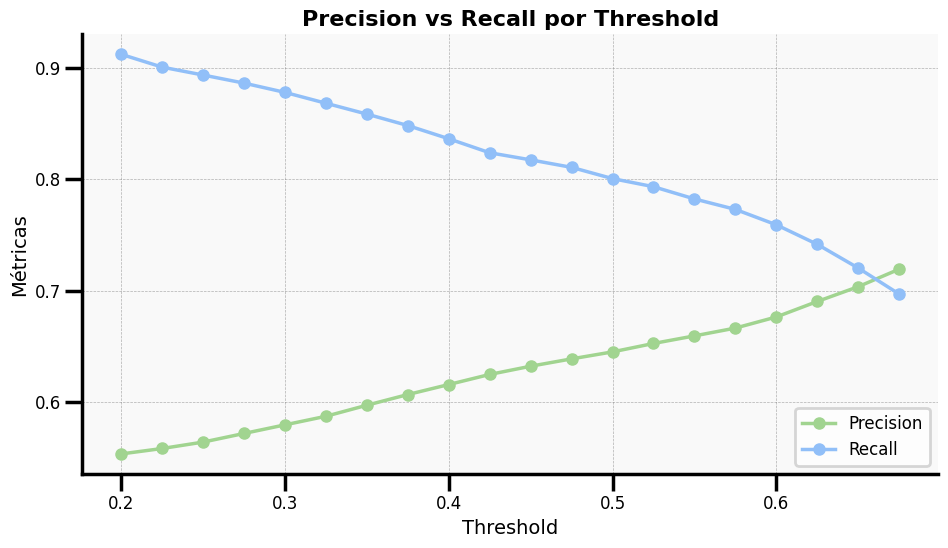

In [ ]:
from utility_funcs import plot_precision_recall_by_threshold

plot_precision_recall_by_threshold(metrics_table_val)

In [ ]:
# Avaliação no Teste
y_test_pred_probs = model.predict(x_test_scaled).ravel()
y_test_pred = (y_test_pred_probs >= 0.35).astype(int)

print("\nMétricas no Conjunto de Teste:")
print(classification_report(y_test, y_test_pred))
print("AUC no Conjunto de Teste:", roc_auc_score(y_test, y_test_pred_probs))

359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Métricas no Conjunto de Teste:
              precision    recall  f1-score   support

           0       0.74      0.35      0.48      4984
           1       0.65      0.90      0.75      6488

    accuracy                           0.66     11472
   macro avg       0.69      0.63      0.62     11472
weighted avg       0.69      0.66      0.63     11472

AUC no Conjunto de Teste: 0.693231565423659
